In [15]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271]

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [4]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [5]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [6]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [7]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [8]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [9]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

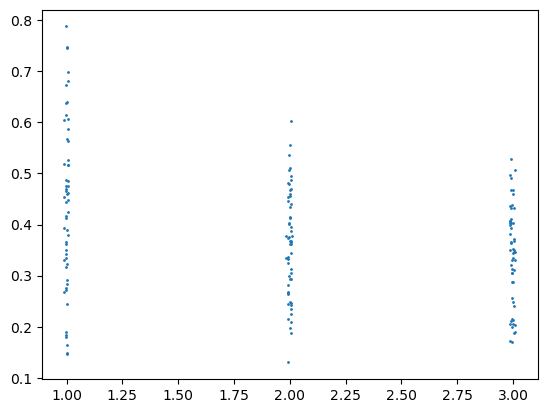

In [10]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

In [11]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [12]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(166, 3)


In [13]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [17]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/Models/model_100206_11g_04.pt"))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=166, out_features=166, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=166, out_features=166, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=166, out_features=166, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=166, out_features=166, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=166, out_features=166, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=166, out_features=166, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=166, out_features=5, bias=True)
  )
)

In [24]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.58it/s]


Loss: 406.7609607982449
Average Loss: 0.055659682648911454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.09it/s]


Loss: 406.81250722776167
Average Loss: 0.05566673607385901
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.40it/s]


Loss: 406.84128398052417
Average Loss: 0.05567067377949154
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.39it/s]


Loss: 406.8137493832037
Average Loss: 0.05566690604586805
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.07it/s]


Loss: 406.90568050392903
Average Loss: 0.05567948556430337
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.59it/s]


Loss: 406.902698835358
Average Loss: 0.05567907756367789
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.91it/s]


Loss: 406.93055001925677
Average Loss: 0.05568288861785123
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.00it/s]


Loss: 407.02882782393135
Average Loss: 0.055696336593312995
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.97it/s]


Loss: 406.7905097818002
Average Loss: 0.05566372602378219
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.07it/s]


Loss: 406.85352642135695
Average Loss: 0.055672348990333465
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 9


  2%|███                                                                                                                                                           | 142/7308 [00:02<00:42, 166.75it/s]

X_batch: 
torch.Size([128, 166])
tensor([[0.3058, 0.3085, 0.1473,  ..., 0.3263, 0.2214, 0.2244],
        [0.6640, 0.3567, 0.1596,  ..., 0.5381, 0.1061, 0.4672],
        [0.3468, 0.4676, 0.2001,  ..., 0.5554, 0.3827, 0.2602],
        ...,
        [0.3139, 0.2320, 0.1319,  ..., 0.2974, 0.1474, 0.2343],
        [0.5763, 0.2438, 0.2342,  ..., 0.4793, 0.1830, 0.1778],
        [0.5254, 0.3205, 0.2147,  ..., 0.4596, 0.1652, 0.2089]])
X_pred: 
torch.Size([128, 166])
tensor([[0.3561, 0.2794, 0.1317,  ..., 0.3511, 0.2127, 0.2011],
        [0.5467, 0.3979, 0.0676,  ..., 0.5247, 0.0727, 0.3880],
        [0.4999, 0.3773, 0.3489,  ..., 0.4977, 0.3448, 0.3305],
        ...,
        [0.3193, 0.2299, 0.1567,  ..., 0.3476, 0.2165, 0.2005],
        [0.5434, 0.3155, 0.2014,  ..., 0.5527, 0.2122, 0.3222],
        [0.5372, 0.2597, 0.2432,  ..., 0.5115, 0.1913, 0.2674]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.91it/s]


Loss: 406.7555756517686
Average Loss: 0.05565894576515717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.44it/s]


Loss: 406.78250789269805
Average Loss: 0.05566263107453449
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.50it/s]


Loss: 406.8056565183215
Average Loss: 0.05566579864782724
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.10it/s]


Loss: 406.7849817886017
Average Loss: 0.05566296959340473
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.74it/s]


Loss: 406.887554427376
Average Loss: 0.055677005258261636
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.10it/s]


Loss: 406.8400923681911
Average Loss: 0.055670510723616735
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.34it/s]


Loss: 406.7345275601838
Average Loss: 0.05565606562126215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.77it/s]


Loss: 406.8117476005573
Average Loss: 0.055666632129249764
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.81it/s]


Loss: 406.7818635609001
Average Loss: 0.055662542906527106
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.52it/s]


Loss: 406.82466179528274
Average Loss: 0.05566839926043825
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.92it/s]


Loss: 406.7756346538663
Average Loss: 0.05566169056566315
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.78it/s]


Loss: 406.811848489102
Average Loss: 0.05566664593446934
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.90it/s]


Loss: 406.7040901009459
Average Loss: 0.055651900670627516
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.36it/s]


Loss: 406.69841475156136
Average Loss: 0.05565112407656833
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.38it/s]


Loss: 406.72625120938756
Average Loss: 0.05565493311567974
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.39it/s]


Loss: 406.75296096294187
Average Loss: 0.05565858798069812
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.14it/s]


Loss: 406.7355850317981
Average Loss: 0.05565621032181146
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.50it/s]


Loss: 406.7717039657291
Average Loss: 0.0556611527046701
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.58it/s]


Loss: 406.6864461970981
Average Loss: 0.055649486343335816
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.59it/s]


Loss: 406.7947467418853
Average Loss: 0.055664305793908776
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.27it/s]


Loss: 406.6462870177347
Average Loss: 0.05564399110806441
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.95it/s]


Loss: 406.7037748147268
Average Loss: 0.05565185752801406
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.12it/s]


Loss: 406.6914353116881
Average Loss: 0.05565016903553477
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.03it/s]


Loss: 406.73444893420674
Average Loss: 0.05565605486237093
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.35it/s]


Loss: 406.7055582618341
Average Loss: 0.05565210156839547
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.92it/s]


Loss: 406.6769117701333
Average Loss: 0.055648181687210356
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.42it/s]


Loss: 406.7517572743818
Average Loss: 0.05565842327235657
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.48it/s]


Loss: 406.7547215956729
Average Loss: 0.055658828899243694
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.21it/s]


Loss: 406.85233658831567
Average Loss: 0.05567218617793044
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.57it/s]


Loss: 406.7636354279239
Average Loss: 0.055660048635457565
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.68it/s]


Loss: 406.6905918584671
Average Loss: 0.055650053620479895
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.18it/s]


Loss: 406.64729951904155
Average Loss: 0.055644129655041265
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.15it/s]


Loss: 406.78249055868946
Average Loss: 0.055662628702612134
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.44it/s]


Loss: 406.6792052590754
Average Loss: 0.055648495519851585
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.82it/s]


Loss: 406.7171700897161
Average Loss: 0.0556536904884669
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.44it/s]


Loss: 406.652581962524
Average Loss: 0.055644852485293377
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.06it/s]


Loss: 406.5995772341266
Average Loss: 0.055637599512058926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.96it/s]


Loss: 406.71823959890753
Average Loss: 0.055653836836194244
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.58it/s]


Loss: 406.6740830850322
Average Loss: 0.05564779462028355
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.97it/s]


Loss: 406.79132394026965
Average Loss: 0.055663837430250364
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.47it/s]


Loss: 406.6503695398569
Average Loss: 0.05564454974546482
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.41it/s]


Loss: 406.6337607759051
Average Loss: 0.05564227706293173
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.84it/s]


Loss: 406.5929441652261
Average Loss: 0.055636691867162844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.54it/s]


Loss: 406.718657594407
Average Loss: 0.05565389403317009
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.49it/s]


Loss: 406.5911699933931
Average Loss: 0.05563644909597607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.99it/s]


Loss: 406.5706327720545
Average Loss: 0.05563363885769766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.99it/s]


Loss: 406.5655226081144
Average Loss: 0.05563293960154822
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.63it/s]


Loss: 406.58033368200995
Average Loss: 0.055634966294746846
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.83it/s]


Loss: 406.6394303897396
Average Loss: 0.05564305287215922
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.68it/s]


Loss: 406.7050854268018
Average Loss: 0.05565203686737846
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.29it/s]


Loss: 406.6486682018731
Average Loss: 0.055644316940595656
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.70it/s]


Loss: 406.72649838542566
Average Loss: 0.055654966938345055
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.34it/s]


Loss: 406.6546990789939
Average Loss: 0.05564514218377037
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.64it/s]


Loss: 406.6110188132152
Average Loss: 0.055639165135907935
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.80it/s]


Loss: 406.5649449743796
Average Loss: 0.055632860560259935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.45it/s]


Loss: 406.6676567592658
Average Loss: 0.05564691526536204
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.84it/s]


Loss: 406.6069741079118
Average Loss: 0.055638611673222746
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.60it/s]


Loss: 406.594307271298
Average Loss: 0.05563687838961385
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.83it/s]


Loss: 406.6538238977082
Average Loss: 0.05564502242716314
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.81it/s]


Loss: 406.6693472431507
Average Loss: 0.05564714658499599
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.54it/s]


Loss: 406.5823673042469
Average Loss: 0.05563524456817828
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.91it/s]


Loss: 406.66685021063313
Average Loss: 0.055646804900196106
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.43it/s]


Loss: 406.57326498720795
Average Loss: 0.05563399904039518
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.61it/s]


Loss: 406.6048356895335
Average Loss: 0.05563831905987048
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.15it/s]


Loss: 406.6026062932797
Average Loss: 0.05563801399743838
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.90it/s]


Loss: 406.5523817569483
Average Loss: 0.055631141455521116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.66it/s]


Loss: 406.6315597749781
Average Loss: 0.05564197588601233
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.80it/s]


Loss: 406.49606750463136
Average Loss: 0.055623435619134014
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.32it/s]


Loss: 406.5791614316404
Average Loss: 0.05563480588829234
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.93it/s]


Loss: 406.6273959071841
Average Loss: 0.05564140611756761
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.11it/s]


Loss: 406.63929969258606
Average Loss: 0.055643034988038596
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.45it/s]


Loss: 406.5041740187444
Average Loss: 0.055624544884885656
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.53it/s]


Loss: 406.5384167311713
Average Loss: 0.05562923053245365
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.71it/s]


Loss: 406.5222460613586
Average Loss: 0.05562701779712077
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.02it/s]


Loss: 406.6133420590777
Average Loss: 0.05563948304037735
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.84it/s]


Loss: 406.562642959645
Average Loss: 0.055632545560980434
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.81it/s]


Loss: 406.52978703333065
Average Loss: 0.05562804967615362
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.71it/s]


Loss: 406.63756208331324
Average Loss: 0.055642797219938867
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.47it/s]


Loss: 406.58020207169466
Average Loss: 0.0556349482856725
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.09it/s]


Loss: 406.47065996797755
Average Loss: 0.055619958944715046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.20it/s]


Loss: 406.53255851054564
Average Loss: 0.05562842891496246
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.61it/s]


Loss: 406.4849674999714
Average Loss: 0.05562191673508092
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.32it/s]


Loss: 406.5086071633268
Average Loss: 0.055625151500181554
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.04it/s]


Loss: 406.48398402216844
Average Loss: 0.05562178215957422
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.57it/s]


Loss: 406.48722080211155
Average Loss: 0.05562222506870711
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.49it/s]


Loss: 406.4812515748199
Average Loss: 0.05562140826146961
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.38it/s]


Loss: 406.59655494522303
Average Loss: 0.05563718595309565
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.74it/s]


Loss: 406.57049815845676
Average Loss: 0.05563362043766513
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.29it/s]


Loss: 406.44025543751195
Average Loss: 0.055615798499933214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.65it/s]


Loss: 406.47930264193565
Average Loss: 0.05562114157661955
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.60it/s]


Loss: 406.4989906947594
Average Loss: 0.05562383561778317
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.69it/s]


Loss: 406.48134500253946
Average Loss: 0.05562142104577716
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.68it/s]


Loss: 406.5457974472083
Average Loss: 0.05563024048265029
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.56it/s]


Loss: 406.57609451562166
Average Loss: 0.0556343862227178
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.28it/s]


Loss: 406.47579493233934
Average Loss: 0.05562066159446351
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.49it/s]


Loss: 406.5249905283563
Average Loss: 0.05562739333995023
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.47it/s]


Loss: 406.51337805902585
Average Loss: 0.055625804332105344
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.24it/s]


Loss: 406.5017590993084
Average Loss: 0.05562421443613963
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.49it/s]


Loss: 406.5547483926639
Average Loss: 0.055631465297299384
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.42it/s]


Loss: 406.6294081849046
Average Loss: 0.05564168147029346
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.07it/s]


Loss: 406.55698976060376
Average Loss: 0.05563177199789324
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.50it/s]


Loss: 406.53869590722024
Average Loss: 0.05562926873388345
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.44it/s]


Loss: 406.47123314393684
Average Loss: 0.05562003737601763
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.28it/s]


Loss: 406.4875467841048
Average Loss: 0.05562226967489119
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.61it/s]


Loss: 406.51015085633844
Average Loss: 0.055625362733489114
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.40it/s]


Loss: 406.43497903458774
Average Loss: 0.05561507649624901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.38it/s]


Loss: 406.4418675834313
Average Loss: 0.055616019100086386
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.70it/s]


Loss: 406.41131595685147
Average Loss: 0.055611838527210106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.93it/s]


Loss: 406.4074860929977
Average Loss: 0.05561131446264336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.20it/s]


Loss: 406.40616716537625
Average Loss: 0.05561113398541
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.53it/s]


Loss: 406.49015948874876
Average Loss: 0.05562262718784192
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.71it/s]


Loss: 406.5554511002265
Average Loss: 0.05563156145323296
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.79it/s]


Loss: 406.51026566303335
Average Loss: 0.05562537844321748
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.53it/s]


Loss: 406.5535000497475
Average Loss: 0.05563129447861898
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.08it/s]


Loss: 406.4765385577921
Average Loss: 0.05562076334945157
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.70it/s]


Loss: 406.40860622166656
Average Loss: 0.05561146773695492
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.48it/s]


Loss: 406.57356066955253
Average Loss: 0.055634039500486114
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.61it/s]


Loss: 406.450411565369
Average Loss: 0.05561718822733566
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.99it/s]


Loss: 406.46996503300034
Average Loss: 0.05561986385235363
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.57it/s]


Loss: 406.4900682370644
Average Loss: 0.05562261470129507
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.98it/s]


Loss: 406.4578063534573
Average Loss: 0.05561820010310034
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.63it/s]


Loss: 406.386161980452
Average Loss: 0.05560839654904926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.86it/s]


Loss: 406.3931869582739
Average Loss: 0.05560935782132921
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.57it/s]


Loss: 406.4457585136406
Average Loss: 0.05561655152074995
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.83it/s]


Loss: 406.41160699515603
Average Loss: 0.05561187835182759
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.65it/s]


Loss: 406.46281939558685
Average Loss: 0.05561888606945633
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.97it/s]


Loss: 406.43965191440657
Average Loss: 0.055615715916038116
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.05it/s]


Loss: 406.4149505891837
Average Loss: 0.05561233587700927
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.30it/s]


Loss: 406.60749104293063
Average Loss: 0.05563868240872067
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.22it/s]


Loss: 406.39330411469564
Average Loss: 0.05560937385258561
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.72it/s]


Loss: 406.3727481106762
Average Loss: 0.05560656104415383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.66it/s]


Loss: 406.37731924816035
Average Loss: 0.05560718654189386
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.37it/s]


Loss: 406.4202042957768
Average Loss: 0.05561305477501051
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.63it/s]


Loss: 406.372654538136
Average Loss: 0.05560654824002955
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.13it/s]


Loss: 406.35577782266773
Average Loss: 0.055604238891990655
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.94it/s]


Loss: 406.3901663017459
Average Loss: 0.05560894448573425
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.46it/s]


Loss: 406.4078242168762
Average Loss: 0.05561136073027862
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.58it/s]


Loss: 406.5140798136126
Average Loss: 0.0556259003576372
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.23it/s]


Loss: 406.35006951750256
Average Loss: 0.055603457788382944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.22it/s]


Loss: 406.3849205134902
Average Loss: 0.055608226671249344
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.79it/s]


Loss: 406.33763301349245
Average Loss: 0.05560175602264538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.12it/s]


Loss: 406.427059260197
Average Loss: 0.055613992783278186
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.72it/s]


Loss: 406.5641970213037
Average Loss: 0.05563275821309575
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.49it/s]


Loss: 406.4699716772884
Average Loss: 0.055619864761533716
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.90it/s]


Loss: 406.3928619073704
Average Loss: 0.05560931334255205
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.74it/s]


Loss: 406.5724322486203
Average Loss: 0.05563388509149156
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.25it/s]


Loss: 406.4045818632003
Average Loss: 0.05561091705845653
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.37it/s]


Loss: 406.3913996249903
Average Loss: 0.05560911324917765
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.20it/s]


Loss: 406.5036779125221
Average Loss: 0.055624476999524095
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.66it/s]


Loss: 406.4283926761709
Average Loss: 0.05561417524304473
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.88it/s]


Loss: 406.31770333694294
Average Loss: 0.055599028918574565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.31it/s]


Loss: 406.3831514811609
Average Loss: 0.05560798460333346
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.51it/s]


Loss: 406.47888942435384
Average Loss: 0.05562108503343648
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.72it/s]


Loss: 406.3993194506038
Average Loss: 0.05561019696915761
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.76it/s]


Loss: 406.46741983434185
Average Loss: 0.05561951557667513
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.15it/s]


Loss: 406.35449328110553
Average Loss: 0.05560406312001991
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.91it/s]


Loss: 406.34421323030256
Average Loss: 0.055602656435454645
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.62it/s]


Loss: 406.4579055355862
Average Loss: 0.05561821367482022
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.99it/s]


Loss: 406.4913624175824
Average Loss: 0.05562279179222529
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.66it/s]


Loss: 406.3314722958021
Average Loss: 0.05560091301256186
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.02it/s]


Loss: 406.4222697415389
Average Loss: 0.055613337403056774
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.20it/s]


Loss: 406.3880437731277
Average Loss: 0.05560865404667867
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.67it/s]


Loss: 406.46218180214055
Average Loss: 0.05561879882350035
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.64it/s]


Loss: 406.39800927974284
Average Loss: 0.05561001769016733
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.58it/s]


Loss: 406.52299720817246
Average Loss: 0.05562712058130439
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.21it/s]


Loss: 406.3281207936816
Average Loss: 0.05560045440526568
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.29it/s]


Loss: 406.379591857316
Average Loss: 0.05560749751742145
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.49it/s]


Loss: 406.3915835393127
Average Loss: 0.05560913841534109
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.22it/s]


Loss: 406.34995140950195
Average Loss: 0.055603441626915974
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.02it/s]


Loss: 406.4709399964195
Average Loss: 0.05561999726278318
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.00it/s]

Loss: 406.34471065877005
Average Loss: 0.05560272450174741
Done, best loss: 406.31770333694294
Done


<All keys matched successfully>

In [22]:
torch.save(final_model, 'model_100206_11g_04_update2.pt')